## Exploratory analysis of the MM-WHS dataset

In [1]:
# imports 
import numpy as np
import os
import monai
from monai.data import CacheDataset, DataLoader, GridPatchDataset
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
    MapLabelValued,
    LoadImage,
    Rotated,
    Flipd,
    SpatialPadd,
    
)

import math
import matplotlib.pyplot as plt
import glob
import torch
import SimpleITK as sitk

In [2]:
example_data_dir = 'preprocessed/ct_examples'
images = sorted(glob.glob(os.path.join(example_data_dir, "images/*.nii.gz")))
labels = sorted(glob.glob(os.path.join(example_data_dir, "labels/*.nii.gz")))
print(f"image: {images}, label: {labels}")

check_files = [{"img": img, "seg": seg} for img, seg in zip(images, labels)]

image: ['preprocessed/ct_examples/images/slice_1.nii.gz', 'preprocessed/ct_examples/images/slice_2.nii.gz', 'preprocessed/ct_examples/images/slice_3.nii.gz', 'preprocessed/ct_examples/images/slice_4.nii.gz'], label: ['preprocessed/ct_examples/labels/slice_1.nii.gz', 'preprocessed/ct_examples/labels/slice_2.nii.gz', 'preprocessed/ct_examples/labels/slice_3.nii.gz', 'preprocessed/ct_examples/labels/slice_4.nii.gz']


In [13]:
check_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        SqueezeDimd(keys=["img", "seg"], dim=-1),
        Resized(keys=["img", "seg"], spatial_size=[256,256]),
        EnsureTyped(keys=["img", "seg"]),
        # FOR MRI: 
        #SpatialPadd(keys=["img", "seg"], spatial_size=[256,256]),
    ]
)

In [14]:
check_ds = CacheDataset(data=check_files, transform=check_transforms, cache_rate=1.0, num_workers=4) # experiment with last two parameters
check_loader = DataLoader(check_ds, batch_size=1)

for batch in check_loader:
    print(batch["img"].shape, batch["seg"].shape)
    

Loading dataset: 100%|██████████| 4/4 [00:00<00:00, 70.59it/s]


torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


# Example CT dataset

In [7]:
data_dir = "../MMWHS_Dataset/ct_train"
images = sorted(glob.glob(os.path.join(data_dir, "ct_train_1001_image.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_dir, "ct_train_1001_label.nii.gz")))

example_dataset = [{"img": img, "seg": seg} for img, seg in zip(images, labels)]
print(len(example_dataset))


1


In [8]:
volume_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys="img"), # normalization between 0 and 1
        EnsureTyped(keys=["img", "seg"]),   
    ]
)

In [9]:
volume_ds_person1 = CacheDataset(data=example_dataset, transform=volume_transforms, cache_rate=1.0, num_workers=4) # experiment with last two parameters
check_loader = DataLoader(volume_ds_person1, batch_size=1)
check_data = monai.utils.misc.first(check_loader)

Loading dataset: 100%|██████████| 1/1 [01:14<00:00, 74.24s/it]


In [11]:
print("first volume's shape", check_data["img"].shape, check_data["seg"].shape)

middle_image = check_data["img"][0, :, :, 75]
middle_label = check_data["seg"][0, :, :, 75]
print("image shape", middle_image.shape, "label shape", middle_label.shape)

first volume's shape torch.Size([1, 1, 512, 512, 363]) torch.Size([1, 1, 512, 512, 363])
image shape torch.Size([1, 512, 363]) label shape torch.Size([1, 512, 363])


In [12]:
patch_func = monai.data.PatchIterd(
    keys=["img", "seg"],
    patch_size=(None, None, 1),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["img", "seg"], dim=-1),  # squeeze the last dim
        #Rotated(keys=["img", "seg"], angle=math.radians(180)),
        Flipd(keys=["img", "seg"], spatial_axis=1),
        MapLabelValued(keys=["seg"], orig_labels=[205, 420, 500, 550, 600, 820, 850], target_labels=[1, 2, 3, 4, 5 , 6 , 7]),
    ]
)

example_patch_ds = GridPatchDataset(data=volume_ds_person1, patch_iter=patch_func, transform=patch_transform)
patch_data_loader = DataLoader(example_patch_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())


In [13]:
i = 1
current_directory = os.getcwd()
output_dir_image = "preprocessed/ct_examples/images"
output_dir_label = "preprocessed/ct_examples/labels"

os.makedirs(output_dir_image, exist_ok=True)
os.makedirs(output_dir_label, exist_ok=True)

for batch in patch_data_loader:
    image, label = batch[0]["img"], batch[0]["seg"]
    if torch.any(label.data != 0).item():
        image = image.squeeze(0)
        label = label.squeeze(0)
        print("image shape", image.shape, "label shape", label.shape)

        # Convert the torch tensor to a SimpleITK image
        slice_image = sitk.GetImageFromArray(image)
        slice_label = sitk.GetImageFromArray(label)
        # # Save the 2D slice as a NIfTI file
        sitk.WriteImage(slice_image, os.path.join(output_dir_image, f"slice_{i}.nii.gz"))
        sitk.WriteImage(slice_label, os.path.join(output_dir_label, f"slice_{i}.nii.gz"))
        i += 1
        if i == 5:
            break

print("Total number of slices:", i)

    

image shape torch.Size([1, 512, 512]) label shape torch.Size([1, 512, 512])
image shape torch.Size([1, 512, 512]) label shape torch.Size([1, 512, 512])
image shape torch.Size([1, 512, 512]) label shape torch.Size([1, 512, 512])
image shape torch.Size([1, 512, 512]) label shape torch.Size([1, 512, 512])
Total number of slices: 5


In [16]:
file_original = "preprocessed/ct_examples/images/slice_original.nii.gz"
example_im_original = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(file_original).squeeze(3).squeeze(3)
print(f"image data shape: {example_im_original.shape}")

label_original = "preprocessed/ct_examples/labels/slice_original.nii.gz"
example_label_original = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(label_original).squeeze(3).squeeze(3)
print(f"label data shape: {example_label_original.shape}")

image data shape: torch.Size([512, 512, 1])
label data shape: torch.Size([512, 512, 1])


In [20]:
file_rot = "preprocessed/ct_examples/images/slice_rot.nii.gz"
example_im_rot = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(file_rot).squeeze(3).squeeze(3)
print(f"image data shape: {example_im_rot.shape}")

label_rot = "preprocessed/ct_examples/labels/slice_rot.nii.gz"
example_label_rot= LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(label_rot).squeeze(3).squeeze(3)
print(f"label data shape: {example_label_rot.shape}")

image data shape: torch.Size([512, 512, 1])
label data shape: torch.Size([512, 512, 1])


In [37]:
file_rot_flip = "preprocessed/ct_examples/images/slice_flip_new.nii.gz"
example_im_rot_flip = LoadImage(image_only=True, simple_keys=True)(file_rot_flip)#.squeeze(3).squeeze(3)
print(f"image data shape: {example_im_rot_flip.shape}")

label_rot_flip = "preprocessed/ct_examples/labels/slice_flip_new.nii.gz"
example_label_rot_flip = LoadImage(image_only=True, simple_keys=True)(label_rot_flip)#.squeeze(3).squeeze(3)
print(f"label data shape: {example_label_rot_flip.shape}")

image data shape: torch.Size([512, 512, 1])
label data shape: torch.Size([512, 512, 1])


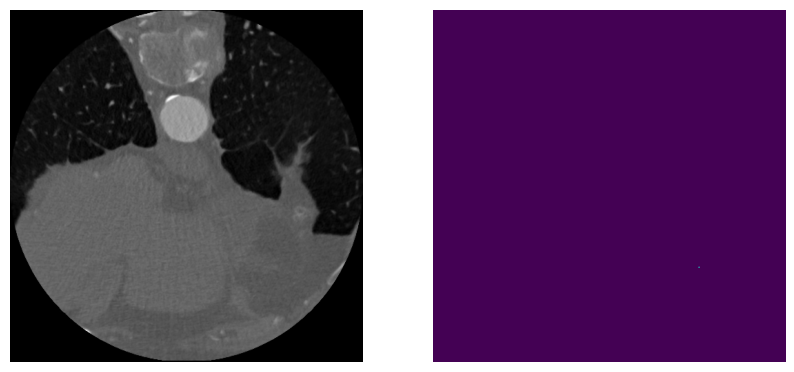

In [25]:
# if torch.allclose(example_im, middle_image.T):# and torch.allclose(example_label, middle_label.T):
#     print("The image data are the same!")
    # label is not the same due to chance in the MapLabelValued transform  

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(example_im_original, cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(example_label_original)

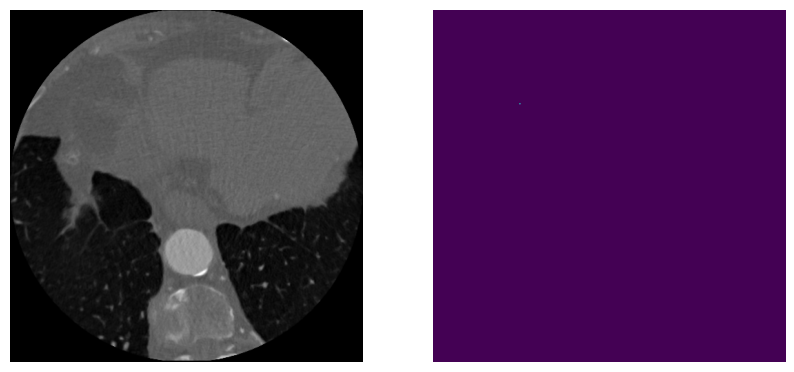

In [26]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(example_im_rot, cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(example_label_rot)

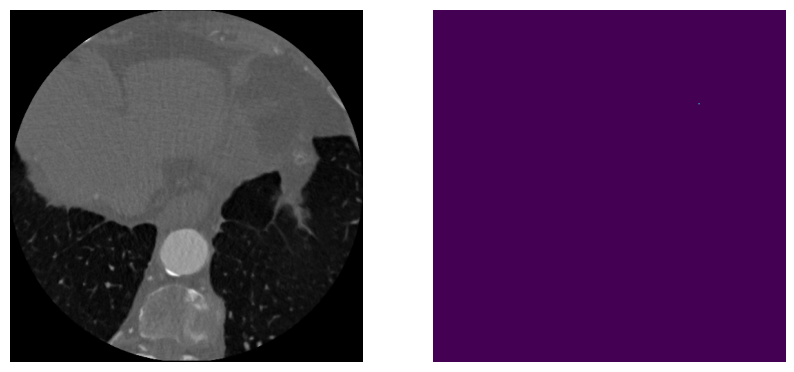

In [38]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(example_im_rot_flip, cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(example_label_rot_flip)